## Dataset preparation

As in any MIS process, we first need to load and prepare data in a suitable graph format. For this tutorial, we will use the standard benchmark [DIMACS datasets](https://oeis.org/A265032/a265032.html) of various sizes and convert them to supported [Networkx](https://networkx.org/documentation/stable/index.html#) graph types.

In [1]:
# Ignore warnings for this tutorial.
import logging
import os
import sys

logger = logging.getLogger()
logger.disabled = True

sys.stderr = open(os.devnull, 'w')

In [2]:
import networkx as nx

# Create a new networkx graph instance to be populated with DIMACS data.
graph = nx.Graph()


with open("./datasets/dimacs/a265032_1tc.16.txt", "r") as f:
    for line in f:
        if line.startswith("c"):  # Comment line in DIMACS file.
            continue
        elif line.startswith("p"):  # Problem definition, i.e. # nodes and edges.
            _, _, num_nodes, num_edges = line.strip().split()
            # Preset graph node labels as there might be isolated ones.
            graph.add_nodes_from(range(1, int(num_nodes) + 1))

        elif line.startswith("e"):
            _, node1, node2 = line.strip().split()
            graph.add_edge(int(node1), int(node2))

# Let's check what the graph looks like.
print(graph)


Graph with 16 nodes and 22 edges


## Solving MIS using a non-quantum solver

Let's first solve this instance of MIS using standard heuristics.

preprocessing - current kernel size is 16
preprocessing - complete


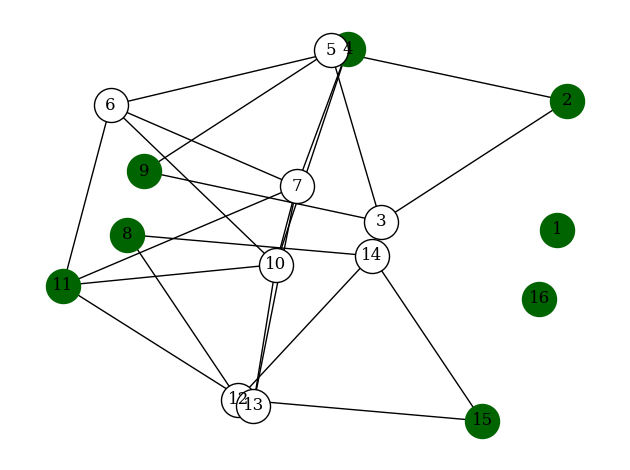

Solution nodes:  [1, 2, 4, 8, 9, 11, 15, 16]
Solution frequency: 1.0
Solution size: 8


In [3]:
from mis import MISSolver, MISInstance, SolverConfig
# Define classical solver configuration

# Use a default configuration for the library.
# By default, the library uses a classical (non-quantum)
# heuristic solver.
config = SolverConfig()

# Create the MIS instance.
instance = MISInstance(graph)

# Run the solver and retrieve results.
solver = MISSolver(instance, config)
solutions = solver.solve()

# Display results
solutions[0].draw()
print("Solution nodes: ", solutions[0].nodes)
print("Solution frequency:", solutions[0].frequency)
print("Solution size:", solutions[0].size)

In this instance, we have used the default (non-quantum) solver. This solver is based on the [approximate MIS solver in Networkx](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.approximation.clique.maximum_independent_set.html). From its inherent heuristic and non-deterministic nature, this solver does not guarantee optimality in solution finding.

The solver returns a list of node labels of size 12 which is the unique solution so far (frequency of 1.0).

## Solving using the quantum SDK QuTiP

In the previous section, we have used a non-quantum solver to resolve our instance of MIS. In this section, we'll use actually use a quantum algorithm. There are three steps to quantum algorithms:

1. Converting the problem into a Register (the position of atoms in the quantum device) and a set of Pulses (the configuration of lasers on the quantum device)
2. Actually running the Register and Pulse on the quantum device
3. Extracting the results of quantum measurement on the quantum device into a solution to the original problem.

In this library, all three steps are entrusted to _backends_. This library provides several backends, depending on your use. Since you may not have access to a quantum computer for step 2, we will use the `QutipBackend`. This is a simple backend that has the advantage of working on most computers, regardless of operating system or GPU.

MIS solution: [1, 4, 8, 9, 13, 15, 16, 2]
Solution frequency: 0.16600000000000006
Solution size: 8


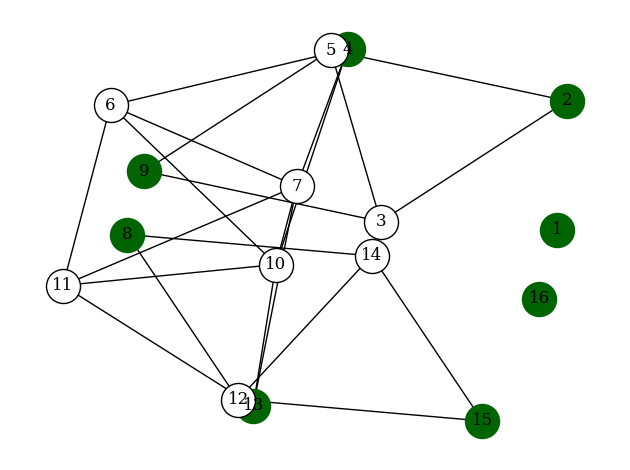

In [4]:
from mis import BackendConfig, BackendType
from pulser.devices import VirtualDevice, AnalogDevice
from dataclasses import replace

VirtualAnalog = replace(AnalogDevice.to_virtual(), max_radial_distance=900)

# deactivate preprocessor to run on quantum, as preprocessor will skip running on device
solver_config = SolverConfig(
    # Use the QuTIP backend.
    backend = BackendConfig(
        backend = BackendType.QUTIP,
        device=VirtualAnalog,
    ),
    # Perform up to 10 quantum measures.
    max_iterations=10,
    preprocessor=None,
    
)

# Run the solver
solver = MISSolver(instance, solver_config)
solutions = solver.solve()

# Display results
print("MIS solution:", solutions[0].nodes)
print("Solution frequency:", solutions[0].frequency)
print("Solution size:", solutions[0].size)
solutions[0].draw()

Note that any quantum algorithm is, by definition, non-deterministic, so there is no guarantee
that this will be the same solution as the non-quantum solver.